# Forecasting

Useful links:
- [DLM tutorial](http://pyro.ai/examples/forecasting_dlm.html). 
- [Modelling mutivariate switching dynamics - advice on getting started?](https://forum.pyro.ai/t/modelling-mutivariate-switching-dynamics-advice-on-getting-started/4017/3)
- [Deep Markov Models](http://pyro.ai/examples/dmm.html#Guide)
- [Forecasting](https://docs.pyro.ai/en/stable/contrib.forecast.html)
- [Time series](https://docs.pyro.ai/en/stable/contrib.timeseries.html)
- [Enumeration of plates](https://pyro.ai/examples/enumeration.html)
- [HMM example](http://pyro.ai/examples/hmm.html)
- [Poutine](https://docs.pyro.ai/en/dev/poutine.html)
- [AR NN](https://docs.pyro.ai/en/stable/nn.html)
- [Model saving](https://forum.pyro.ai/t/how-to-save-the-best-model-and-guide-during-validation/711/6)

In [62]:
import os
import math

import torch
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoDelta, AutoNormal, AutoDiagonalNormal
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, config_enumerate
from pyro.contrib.tracking.extended_kalman_filter import EKFState
from pyro.contrib.tracking.distributions import EKFDistribution
from pyro.contrib.tracking.dynamic_models import NcvContinuous
from pyro.contrib.tracking.measurements import PositionMeasurement
import pyro.poutine as poutine
from pyro.contrib.forecast import ForecastingModel, Forecaster, eval_crps
from pyro.infer.reparam import LocScaleReparam, AutoReparam
from pyro.ops.stats import quantile

from main import get_energy_data, get_weather_data
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pickle

pyro.set_rng_seed(20200928)
torch.manual_seed(20200101)

pd.set_option('display.max_rows', 500)



## Data

In [4]:
T = None # number of time steps to include, if None all data is used
test_frac = 0.1 # fraction of data to use for testing

# read data
df = pd.read_csv("preprocessed_data/df.csv")#.iloc[:1000]
df["time_str"] = [d.split("+")[0] for d in df["time_str"]]
df["time_str"] = pd.to_datetime(df["time_str"], infer_datetime_format=True)#'%Y-%m-%d %H:%M:%S.%f') # 2015-01-01 10:00:00+00:00
df = df.groupby("time_str").mean()
df = df.reset_index().set_index('time_str')
df.index.name = None
df = df.asfreq("D") # aggregate data, can be commented out to use all data
dfW = get_weather_data(df)
dfE = get_energy_data(df)


# start, train end, test end
n = len(df) if T is None else T
T0 = 0
T1 = n - int(test_frac*n) # 10 % test data
T2 = n
print("Number of observations:", n)
print("Number of training observations:", T1 - T0)
print("Number of test observations:", T2 - T1)


# standardize data
df_standardized = dfE.merge(dfW, left_index=True, right_index=True)
df_standardized["price_ actual"] = df["price actual"]
scaler = StandardScaler().fit(df_standardized[:T1])
df_standardized = scaler.transform(df_standardized)
df_standardized = pd.DataFrame(df_standardized, columns=list(dfW.columns) + list(dfE.columns) + ["price_actual"], index = df.index)
# print(df_standardized.columns)

# create tensors
X_W = torch.from_numpy(df_standardized[dfW.columns].values).float()
X_E = torch.from_numpy(df_standardized[dfE.columns].values).float()
obs = torch.from_numpy(df_standardized["price_actual"].values).float()

# translate to pyro forecasting language
y = obs.unsqueeze(-1) if T is None else obs[-T:].unsqueeze(-1)
covariates = torch.hstack((X_E, X_W)) if T is None else torch.hstack((X_E, X_W))[-T:]

# define constants
n, p = covariates.shape
dates = df.index[-n:] # used for plotting



Number of observations: 1461
Number of training observations: 1315
Number of test observations: 146


### Helper functions



In [94]:
def train(model, num_steps, model_name = "latest_model", save = False, **kwargs):
    pyro.set_rng_seed(1)
    pyro.clear_param_store()
    model = model()
    guide =  AutoNormal(poutine.block(model, hide=[f"z_{i}" for i in range(T1+1)])) 
    
    # guide = AutoDiagonalNormal(model)
    # optim = Adam({ 'lr': 1e-3 })
    forecaster = Forecaster(
        model,
        y[:T1],
        covariates[:T1],
        learning_rate=0.1,
        learning_rate_decay=0.05,
        num_steps=num_steps,
        guide = guide,
        **kwargs
        # optim = optim,
    )

    if save:
        with open(f"models/{model_name}.pkl", "wb") as f:
            pickle.dump(forecaster, f)

    return forecaster

def load_forecaster(model_name = "latest_model"):
    with open(f"models/{model_name}.pkl", "rb") as f:
        forecaster = pickle.load(f)
    return forecaster


def sample_from_posterior(forecaster, num_samples = 100):
    forecaster = load_forecaster(forecaster) if isinstance(forecaster, str) else forecaster
    
    with poutine.trace() as tr:
        forecaster(y[:T1], covariates, num_samples=num_samples)

    # extract the values from the recorded trace
    posterior_samples = {
        name: site["value"]
        for name, site in tr.trace.nodes.items()
        if site["type"] == "sample"
    }

    return posterior_samples

def eval_posterior_simple(forecaster, start_idx = 0, end_idx = -1, ax = None):
    pred = sample_from_posterior(forecaster, 100)['prediction'].squeeze(-1).mean(0)

    # plot
    ax = plt if ax is None else ax
    ax.plot(dates, y, label="observed", alpha= .7)
    ax.plot(dates[:T1], pred[:T1], label="train prediction", alpha = .7)
    ax.plot(dates[T1:], pred[T1:], label="test prediction", alpha = .7)
    ax.legend()

    if ax == plt:
        ax.xlim(dates[start_idx], dates[end_idx])
        ax.title("Forecast with " + str(forecaster.model).strip("()"))
    else:
        ax.set_xlim(dates[start_idx], dates[end_idx])
        ax.set_title("Forecast with " + str(forecaster.model).strip("()"))
        plt.setp(ax.get_xticklabels(), rotation = 45)

    # residuals
    resid = obs -pred
    print("Mean price: ", obs.mean())
    print("Mean abs residual: ", resid.abs().mean())
    print("Mean abs train residual: ", resid[:T1].abs().mean())
    print("Mean abs test residual: ", resid[T1:].abs().mean())

## Models

### Vanilla DLM

INFO 	 step    0 loss = 31.247
INFO 	 step  100 loss = 2.72854
INFO 	 step  200 loss = 1.9972
INFO 	 step  300 loss = 1.78429
INFO 	 step  400 loss = 1.88916
INFO 	 step  500 loss = 1.71529
INFO 	 step  600 loss = 1.51906
INFO 	 step  700 loss = 1.56074
INFO 	 step  800 loss = 1.40817
INFO 	 step  900 loss = 1.39608


Mean price:  tensor(0.1096)
Mean abs residual:  tensor(0.6106)
Mean abs train residual:  tensor(0.5711)
Mean abs test residual:  tensor(0.9661)


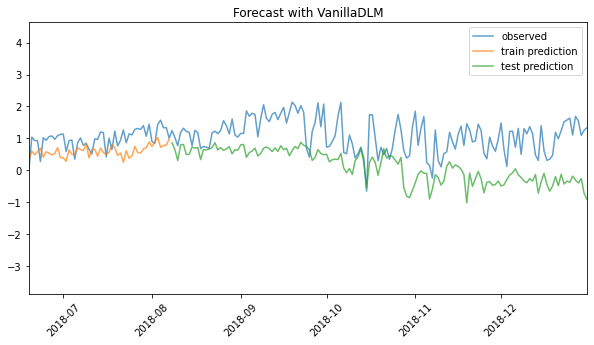

In [85]:
class VanillaDLM(ForecastingModel):
    def model(self, zero_data, covariates):
        x_E = covariates[:, :X_E.shape[1]]
        x_W = covariates[:, -X_W.shape[1]:]
        covariates = x_E
        
        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)

        

        drift_scale = pyro.sample("drift_scale", dist.LogNormal(-10, 10).expand([feature_dim]).to_event(1))
        with self.time_plate:
            with poutine.reparam(config={"drift": LocScaleReparam()}):
                drift = pyro.sample("drift", dist.Normal(torch.zeros(covariates.size()), drift_scale).to_event(1))

        weight = drift.cumsum(-2)  # A Brownian motion.
        # record in model_trace
        pyro.deterministic("weight", weight)

        prediction = (weight * covariates).sum(-1, keepdim=True)
        assert prediction.shape[-2:] == zero_data.shape
        # record in model_trace
        pyro.deterministic("prediction", prediction)

        scale = pyro.sample("noise_scale", dist.LogNormal(-5, 10).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, scale)

        self.predict(noise_dist, prediction)

forecaster = train(VanillaDLM, num_steps=1000, save=False, model_name="VanillaDLM")
# forecaster = load_forecaster("VanillaDLM")

# plot forecast
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
eval_posterior_simple(forecaster, start_idx = T1-50, ax = ax)
plt.show()

### Linear DLM

In [1]:
class LinearDLM(ForecastingModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.tau = 1
        self.M = 4
        self.h_dim = X_E.shape[1]
        self.gamma = 1e-6

    def model(self, zero_data, covariates):
        x_E = covariates[:, :X_E.shape[1]]
        x_W = covariates[:, -X_W.shape[1]:]
        # covariates = x_E

        data_dim = zero_data.size(-1)
        duration = zero_data.size(-2)
        feature_dim = covariates.size(-1)

        # draw parameters
        theta_g = pyro.sample("theta_g", dist.Normal(0,1).expand([feature_dim]).to_event(1))

        # draw hidden states
        if not hasattr(self, 'time_plate'):
            time_plate = pyro.plate("time", duration)
            self._data = zero_data
            self._forecast = None
            with time_plate:
                R = pyro.sample("R", dist.HalfCauchy(self.gamma*torch.ones(feature_dim)).to_event(1))
                h = pyro.sample("h", dist.Normal(covariates, R).to_event(1))
        else:
            with self.time_plate:  
                R = pyro.sample("R", dist.HalfCauchy(self.gamma*torch.ones(feature_dim)).to_event(1))
                h = pyro.sample("h", dist.Normal(covariates, R).to_event(1))
        pyro.deterministic("h_data", h)

        # prediction
        prediction = (theta_g*h).sum(-1, keepdim=True)
        assert prediction.shape[-2:] == zero_data.shape
        pyro.deterministic("prediction", prediction) # record in model_trace

        # add noise to prediction 
        sigma = pyro.sample("sigma", dist.HalfCauchy(self.tau).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, sigma)

        self.predict(noise_dist, prediction)

# # get forecaster
# # forecaster = train(LinearDLM, num_steps=1000, save=True, model_name="linear_dlm")
# forecaster = load_forecaster("linear_dlm")

# # plot forecast
# fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# test_implementation(forecaster, start_idx = T1-50, ax = ax)
# plt.show()

LinearDLM().model(y, covariates)
pyro.render_model(LinearDLM().model, model_args = (y, covariates))

NameError: name 'ForecastingModel' is not defined

### Linear DLM with hidden states

INFO 	 step    0 loss = 40.2881
INFO 	 step  100 loss = 2.58418
INFO 	 step  200 loss = 2.23893
INFO 	 step  300 loss = 1.97647
INFO 	 step  400 loss = 1.93889
INFO 	 step  500 loss = 1.89896
INFO 	 step  600 loss = 1.83701
INFO 	 step  700 loss = 1.71415
INFO 	 step  800 loss = 1.74231
INFO 	 step  900 loss = 1.77415


Mean price:  tensor(0.1096)
Mean abs residual:  tensor(0.7518)
Mean abs train residual:  tensor(0.7031)
Mean abs test residual:  tensor(1.1905)


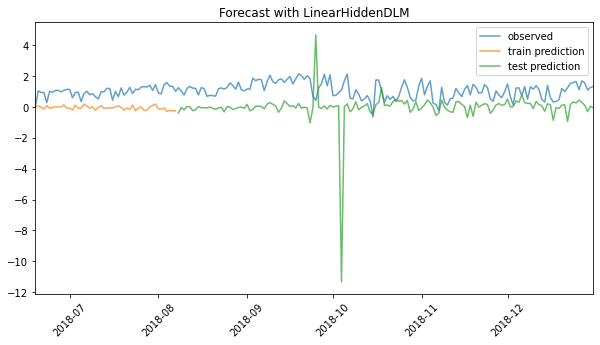

In [95]:
class LinearHiddenDLM(ForecastingModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.tau = 1
        self.M = 4
        # self.h_dim = X_E.shape[1]
        self.h_dim = 10
        self.gamma = 1
        self.lambda_f = 1

    def model(self, zero_data, covariates):
        x_E = covariates[:, :X_E.shape[1]]
        x_W = covariates[:, -X_W.shape[1]:]
        covariates = x_E

        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)

        # draw parameters
        theta_g = pyro.sample("theta_g", dist.Normal(torch.zeros(self.h_dim), torch.ones(self.h_dim)).to_event(1))
        theta_f = pyro.sample("theta_f", dist.Normal(torch.zeros((feature_dim, self.h_dim)), torch.ones((feature_dim, self.h_dim)) * self.lambda_f).to_event(2))
        # print("theta_g: ", theta_g.shape)

        # weight = theta_g

        with self.time_plate:
            R = pyro.sample("R", dist.HalfCauchy(self.gamma*torch.ones(self.h_dim)).to_event(1))
            
            # print(covariates.unsqueeze(-1).shape, theta_f.shape)
            h_mean = (theta_f*covariates.unsqueeze(-1)).sum(-2, keepdim=True).squeeze(-2)
            # print("h_mean: ", h_mean.shape, "R: ",R.shape)
            with poutine.reparam(config={"h": LocScaleReparam()}):
                h = pyro.sample("h", dist.Normal(h_mean, R).to_event(1))
        pyro.deterministic("h_data", h)

        # prediction 
        # print("theta_g: ", theta_g.shape, "h: ", h.shape)
        prediction = (theta_g*h).sum(-1, keepdim=True)
        assert prediction.shape[-2:] == zero_data.shape
        # record in model_trace
        pyro.deterministic("prediction", prediction)

        sigma = pyro.sample("sigma", dist.HalfCauchy(self.tau).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, sigma)

        self.predict(noise_dist, prediction)

# get forecaster
forecaster = train(LinearHiddenDLM, num_steps=1000, save=False, model_name="LinearHiddenDLM")
# forecaster = load_forecaster("LinearHiddenDLM")

# plot forecast
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
eval_posterior_simple(forecaster, start_idx = T1-50, ax = ax)
plt.show()

### Neural Net DLM


INFO 	 step    0 loss = 40.4239
INFO 	 step    1 loss = 37.5344
INFO 	 step    2 loss = 36.1847
INFO 	 step    3 loss = 34.7429
INFO 	 step    4 loss = 33.5592


feature_dim:  23 20
X_prev:  torch.Size([1315, 23])
X_after:  torch.Size([1315, 2])
feature_dim:  23 20
X_prev:  torch.Size([1315, 23])
X_after:  torch.Size([1315, 2])
feature_dim:  23 20
X_prev:  torch.Size([1315, 23])
X_after:  torch.Size([1315, 2])
feature_dim:  23 20
X_prev:  torch.Size([1315, 23])
X_after:  torch.Size([1315, 2])
feature_dim:  23 20
X_prev:  torch.Size([1315, 23])
X_after:  torch.Size([1315, 2])
feature_dim:  23 20
X_prev:  torch.Size([1315, 23])
X_after:  torch.Size([1315, 2])
feature_dim:  23 20
X_prev:  torch.Size([1315, 23])
X_after:  torch.Size([1315, 2])


INFO 	 step    5 loss = 33.3369
INFO 	 step    6 loss = 32.5768
INFO 	 step    7 loss = 31.3514
INFO 	 step    8 loss = 32.2282
INFO 	 step    9 loss = 31.1475


feature_dim:  23 20
X_prev:  torch.Size([1315, 23])
X_after:  torch.Size([1315, 2])
feature_dim:  23 20
X_prev:  torch.Size([1315, 23])
X_after:  torch.Size([1315, 2])
feature_dim:  23 20
X_prev:  torch.Size([1315, 23])
X_after:  torch.Size([1315, 2])
feature_dim:  23 20
X_prev:  torch.Size([1315, 23])
X_after:  torch.Size([1315, 2])
feature_dim:  23 20
X_prev:  torch.Size([1315, 23])
X_after:  torch.Size([1315, 2])
feature_dim:  23 20
X_prev:  torch.Size([1461, 23])


RuntimeError: t() expects a tensor with <= 2 dimensions, but self is 4D

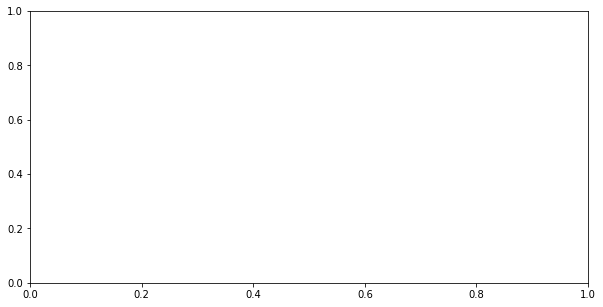

In [97]:
class F(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super(F, self).__init__()
        
        # Architecture
        self.in_layer = torch.nn.Linear(n_in, n_hidden)
        self.h_layer = torch.nn.Linear(n_hidden, n_hidden)
        self.out_layer = torch.nn.Linear(n_hidden, n_out)
        
        # Activation functions
        self.tanh = torch.nn.Tanh()
        
    def forward(self, X):
        # print("X: ", X.shape, "in_layer(X): ", self.in_layer(X).shape)
        # Forward pass
        X = X.squeeze()
        print("X_prev: ", X.shape)
        X = self.in_layer(X)
        print("X_after: ", X.shape)
        X = self.tanh(X)
        X = self.tanh(self.h_layer(X))
        X = self.out_layer(X)
        
        return X

# F = torch.nn.LSTM()

class G(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super(G, self).__init__()
        
        # Architecture
        self.in_layer = torch.nn.Linear(n_in, n_hidden)
        self.h_layer = torch.nn.Linear(n_hidden, n_hidden)
        self.out_layer = torch.nn.Linear(n_hidden, n_out)
        
        # Activation functions
        self.tanh = torch.nn.Tanh()
        
    def forward(self, X):
        # Forward pass
        X = self.in_layer(X)
        X = self.tanh(X)
        X = self.tanh(self.h_layer(X))
        X = self.out_layer(X)
        
        return X

def init_nnet(n_f_features, n_g_features, h_dim=10, lambda_f = 1, lambda_g = 1):
    # Initialize the neural network from PyTorch 
    f_torch = F(n_in=n_f_features, n_hidden=2, n_out=h_dim)
    # f_torch = torch.nn.LSTM(input_size = n_f_features, hidden_size = h_dim, num_layers = 4)
    g_torch = G(n_in=n_g_features, n_hidden=6, n_out=1) 

    # Convert the PyTorch neural net into a Pyro model with priors
    f_priors = {} # Priors for the neural model
    for name, par in f_torch.named_parameters():     # Loop over all neural network parameters
        # print(name, par.shape)
        f_priors[name] = dist.Normal(torch.zeros(*par.shape), lambda_f*torch.ones(*par.shape)).to_event()#.independent(1) # Each parameter has a N(0, 1) prior

    g_priors = {} # Priors for the neural model
    for name, par in g_torch.named_parameters():     # Loop over all neural network parameters
        g_priors[name] = dist.Normal(torch.zeros(*par.shape), lambda_g*torch.ones(*par.shape)).to_event()#.independent(1) # Each parameter has a N(0, 1) prior

    # Make this model and these priors a Pyro model
    f_bayesian = pyro.random_module('f_bayesian_model', f_torch, f_priors)
    g_bayesian = pyro.random_module('g_bayesian_model', g_torch, g_priors)

    # Initialize the models 
    f = f_bayesian()     
    g = g_bayesian() 

    return f, g

class NeuralNetDLM(ForecastingModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.tau = 1
        self.M = 4
        # self.h_dim = X_E.shape[1]
        self.h_dim = 20
        self.gamma = 1
        self.lambda_f = 1
        self.lambda_g = 1

    def model(self, zero_data, covariates):
        x_E = covariates[:, :X_E.shape[1]]
        x_W = covariates[:, -X_W.shape[1]:]
        # covariates = x_E

        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)

        # draw parameters
        # theta_g = pyro.sample("theta_g", dist.Normal(torch.zeros(self.h_dim), torch.ones(self.h_dim)).to_event(1))
        # theta_f = pyro.sample("theta_f", dist.Normal(torch.zeros((feature_dim, self.h_dim)), torch.ones((feature_dim, self.h_dim)) * self.lambda_f).to_event(2))
        # print("theta_g: ", theta_g.shape)
        print("feature_dim: ", feature_dim, self.h_dim)
        f, g = init_nnet(feature_dim, self.h_dim, h_dim=self.h_dim, lambda_f = self.lambda_f, lambda_g = self.lambda_g) # neural networks f and g
        R = pyro.sample("R", dist.HalfCauchy(self.gamma).expand([self.h_dim]).to_event(1)) # covariance matrix


        # weight = theta_g

        with self.time_plate:
            # R = pyro.sample("R", dist.HalfCauchy(self.gamma*torch.ones(self.h_dim)).to_event(1))
            
            # print(covariates.unsqueeze(-1).shape, theta_f.shape)
            # h_mean = (theta_f*covariates.unsqueeze(-1)).sum(-2, keepdim=True).squeeze(-2)
            # print("covariates: ", covariates.shape)
            h_mean = f(covariates)
            # print("h_mean: ", h_mean.shape, "R: ",R.shape)
            with poutine.reparam(config={"h": LocScaleReparam()}):
                h = pyro.sample("h", dist.Normal(h_mean, R).to_event(1))
        pyro.deterministic("h_data", h)

        # print("h_mean: ", h_mean.shape, "R: ",R.shape, "h: ", h.shape)

        # prediction 
        # print("theta_g: ", theta_g.shape, "h: ", h.shape)
        # prediction = (theta_g*h).sum(-1, keepdim=True)
        prediction = g(h)
        assert prediction.shape[-2:] == zero_data.shape
        # record in model_trace
        pyro.deterministic("prediction", prediction)

        sigma = pyro.sample("sigma", dist.HalfCauchy(self.tau).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, sigma)

        self.predict(noise_dist, prediction)

def train(model, num_steps, model_name = "latest_model", save = False, **kwargs):
    pyro.set_rng_seed(1)
    pyro.clear_param_store()
    model = model()
    guide =  AutoDiagonalNormal(model)
    
    # guide = AutoDiagonalNormal(model)
    # optim = Adam({ 'lr': 1e-3 })
    forecaster = Forecaster(
        model,
        y[:T1],
        covariates[:T1],
        learning_rate=0.1,
        learning_rate_decay=0.05,
        num_steps=num_steps,
        guide = guide,
        **kwargs
        # optim = optim,
    )

    if save:
        with open(f"models/{model_name}.pkl", "wb") as f:
            pickle.dump(forecaster, f)

    return forecaster

# get forecaster
# guide = AutoDiagonalNormal(NeuralNetDLM)
# guide = AutoNormal(poutine.block(NeuralNetDLM, hide=[f"z_{i}" for i in range(T1+1)]))
forecaster = train(NeuralNetDLM, num_steps=10, save=True, model_name="NeuralNetDLM", log_every = 1)
# forecaster = load_forecaster("NeuralNetDLM")

# plot forecast
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
eval_posterior_simple(forecaster, start_idx = T1-50, ax = ax)
plt.show()

### AR

In [110]:
class AR(ForecastingModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.tau = 1
        self.M = 4
        # self.h_dim = X_E.shape[1]
        self.h_dim = 20
        self.gamma = 1
        self.lambda_f = 1
        self.order = 1

    def model(self, zero_data, covariates):
        x_E = covariates[:, :X_E.shape[1]]
        x_W = covariates[:, -X_W.shape[1]:]
        # covariates = x_E

        data_dim = zero_data.size(-1)
        duration = zero_data.size(-2)
        feature_dim = covariates.size(-1)


        # draw parameters
        phi = pyro.sample("phi", dist.Normal(0,1).expand([self.order]).to_event(1))

        # init y
        # ys = []
        # y = pyro.sample("y_0", dist.Normal(0, 1).expand([1]).to_event(1))
        # ys.append(y)
        # print("y: ", y.shape, "ys: ", ys.shape)
        # ys = torch.stack([y], dim = 1)
        # ys = y
        # print("y: ", y.shape, "ys: ", ys.shape)
        # ys = y

        # y_plate = pyro.plate("y_plate", duration, dim=-2)
        for t in pyro.markov(range(duration+1), history=self.order):
            if t == 0:
                y[t] = pyro.sample("y_0", dist.Normal(0, 1).expand([1]).to_event(1))
            else:
                y[t] = pyro.sample("y_" + str(t), dist.Normal(phi*y[t-1], torch.ones_like(y[t-1])).to_event(1))
            # print("y: ", y.shape, "ys: ", ys.shape)
            # ys = torch.hstack([ys, y])
            # ys.append(y)
            # print("ys: ", ys.shape, "y: ", y.shape, y)
            # ys = torch.stack([ys, y], dim = 1)

        # ys = torch.stack(ys, dim=0)[1:]
        pyro.deterministic("prediction", y)

        # prediction = ys.squeeze(-1).permute(1,0, )
        # prediction = ys[1:].unsqueeze(-1)
        print(y.shape)
        prediction = y[1:]

        print("prediction: ", prediction.shape, "y: ", y.shape, zero_data.shape)
        

        # prediction = (theta_g*h).sum(-1, keepdim=True)
        assert prediction.shape[-2:] == zero_data.shape
        # record in model_trace
        # pyro.deterministic("prediction", prediction)

        sigma = pyro.sample("sigma", dist.HalfCauchy(self.tau).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, sigma)

        self.predict(noise_dist, prediction)


# get forecaster
forecaster = train(AR, num_steps=2, save=True, model_name="AR", log_every = 1)
# forecaster = load_forecaster("AR")

# plot forecast
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
eval_posterior_simple(forecaster, start_idx = T1-50, ax = ax)
plt.show()

torch.Size([1461, 1])
prediction:  torch.Size([1460, 1]) y:  torch.Size([1461, 1]) torch.Size([1315, 1])


AssertionError: 

### AR DLM

torch.Size([1315, 1])
torch.Size([1315, 1])
torch.Size([1315, 1])


INFO 	 step    0 loss = 13.0722


torch.Size([1315, 1])
torch.Size([100, 1461, 1])
Mean price:  tensor(0.1028)
Mean abs residual:  tensor(4.8063)
Mean abs train residual:  tensor(4.1104)
Mean abs test residual:  tensor(11.0742)


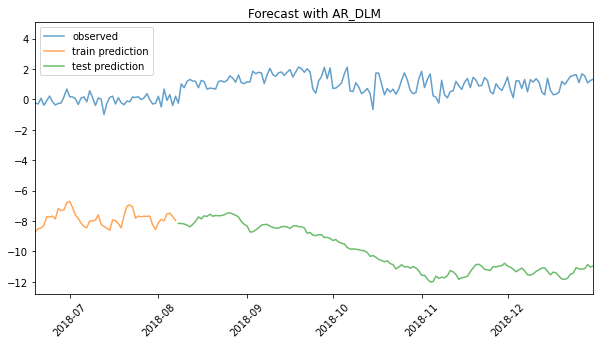

In [114]:
class AR_DLM(ForecastingModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.tau = 1
        self.M = 4
        # self.h_dim = X_E.shape[1]
        self.h_dim = 20
        self.gamma = 1
        self.lambda_f = 1

    def model(self, zero_data, X):
        #x_E = X[:, :X_E.shape[1]]
        #x_W = X[:, -X_W.shape[1]:]

        duration, data_dim = zero_data.size()
        feature_dim = covariates.size(-1)

        #theta_f = pyro.sample("theta_f", dist.Normal(0, self.lambda_f).expand((feature_dim, self.h_dim)).to_event(2))
        #theta_g = pyro.sample("theta_g", dist.Normal(0, 1).expand(self.h_dim).to_event(1))
        alpha = pyro.sample("alpha", dist.Normal(0, 0.01).expand([feature_dim]).to_event(1))
        beta = pyro.sample("beta", dist.Normal(0, 0.01).expand([1]).to_event(1))
        gamma = pyro.sample("gamma", dist.HalfCauchy(self.tau).expand([1]).to_event(1))

        ys = []
        y = pyro.sample("y_0", dist.Normal(0, 1).expand([1]).to_event(1))
        ys.append(y)

        #y_plate = pyro.plate("y")
        for t in pyro.markov(range(duration)):
            y_mean = ys[t] + alpha @ X[t].unsqueeze(-1) + beta
            y = pyro.sample(f"y_{t+1}", dist.Normal(y_mean, torch.ones_like(y_mean) * gamma).to_event(1))
            ys.append(y)

        ys = torch.stack(ys, dim=0)[1:]
        if ys.ndim > 2:
            ys = ys.squeeze(-1).permute(1,0,2)
        print(ys.shape)
        pyro.deterministic("prediction", ys)
        #ys = ys.unsqueeze(-1)

        
        sigma = pyro.sample("sigma", dist.HalfCauchy(self.tau).expand([1]).to_event(1))

        noise_dist = dist.Normal(0, sigma)

        self.predict(noise_dist, ys)

# get forecaster
forecaster = train(AR_DLM, num_steps=2, save=True, model_name="AR_DLM")
# forecaster = load_forecaster("AR_DLM")

# plot forecast
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
eval_posterior_simple(forecaster, start_idx = T1-50, ax = ax)
plt.show()

### AR1

INFO 	 step    0 loss = 5.02328
INFO 	 step  100 loss = 0.629031


Mean price:  tensor(0.1028)
Mean abs residual:  tensor(0.1836)
Mean abs train residual:  tensor(0.0809)
Mean abs test residual:  tensor(1.1088)


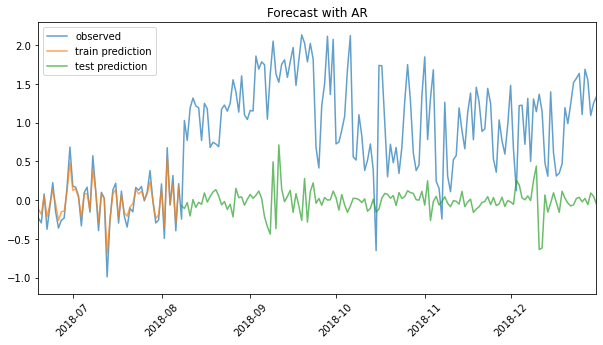

In [130]:
class AR(ForecastingModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.tau = 1
        self.M = 4
        # self.h_dim = X_E.shape[1]
        self.h_dim = 20
        self.gamma = 1
        self.lambda_f = 1
        self.order = kwargs.get("order", 1)

    def model(self, zero_data, X):
        #x_E = X[:, :X_E.shape[1]]
        #x_W = X[:, -X_W.shape[1]:]

        duration, data_dim = zero_data.size()
        feature_dim = covariates.size(-1)

        #theta_f = pyro.sample("theta_f", dist.Normal(0, self.lambda_f).expand((feature_dim, self.h_dim)).to_event(2))
        #theta_g = pyro.sample("theta_g", dist.Normal(0, 1).expand(self.h_dim).to_event(1))
        # alpha = pyro.sample("alpha", dist.Normal(0, 0.01).expand([feature_dim]).to_event(1))
        # beta = pyro.sample("beta", dist.Normal(0, 0.01).expand([1]).to_event(1))
        gamma = pyro.sample("gamma", dist.HalfCauchy(self.tau).expand([1]).to_event(1))

        ys = []
        y = pyro.sample("y_0", dist.Normal(0, 1).expand([self.order]).to_event(1))
        ys.append(y)

        #y_plate = pyro.plate("y")
        for t in pyro.markov(range(duration), history = self.order):
            # y_mean = ys[t] + alpha @ X[t].unsqueeze(-1) + beta
            phi = pyro.sample(f"phi_{t+1}", dist.Normal(0, 1).expand([self.order]).to_event(1))
            # print("phi", phi.shape, ys[t].shape, t)
            y_mean = ys[t] *phi
            y = pyro.sample(f"y_{t+1}", dist.Normal(y_mean, torch.ones_like(y_mean) * gamma).to_event(1))
            ys.append(y)

        ys = torch.stack(ys[1:], dim=0)
        if ys.ndim > 2:
            ys = ys.squeeze(-1).permute(1,0,2)
        # print(ys.shape)
        pyro.deterministic("prediction", ys)
        #ys = ys.unsqueeze(-1)

        
        sigma = pyro.sample("sigma", dist.HalfCauchy(self.tau).expand([1]).to_event(1))

        noise_dist = dist.Normal(0, sigma)

        self.predict(noise_dist, ys)

# get forecaster
# forecaster = train(AR, num_steps=200, save=True, model_name="AR")
forecaster = load_forecaster("AR")

# plot forecast
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
eval_posterior_simple(forecaster, start_idx = T1-50, ax = ax)
plt.show()

## Inference

In [ ]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
model = VanillaDLM()
forecaster = Forecaster(
    model,
    y[:T1],
    covariates[:T1],
    learning_rate=0.1,
    learning_rate_decay=0.05,
    num_steps=1000,
)

In [ ]:
pyro.set_rng_seed(1)
# record all latent variables in a trace
with poutine.trace() as tr:
    forecaster(y[:T1], covariates, num_samples=100)

# extract the values from the recorded trace
posterior_samples = {
    name: site["value"]
    for name, site in tr.trace.nodes.items()
    if site["type"] == "sample"
}

# posterior_samples["prediction"].shape


## Analyze posterior samples

In [ ]:
posterior_samples.keys()

In [ ]:
# extract percentiles of the posterior samples
pred_p10, pred_p50, pred_p90 = quantile(posterior_samples['prediction'], (0.1, 0.5, 0.9)).squeeze(-1)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(dates, y, label="observed", alpha= .4)
ax.plot(dates[:T1], pred_p50[:T1], label="train prediction", alpha = .4)
ax.plot(dates[T1:], pred_p50[T1:], label="test prediction", alpha = .4)
ax.legend()

plt.setp(ax.get_xticklabels(), rotation = 45)

plt.show()

In [ ]:
resid = obs - posterior_samples['prediction'].squeeze()

resid_p10, resid_p50, resid_p90 = quantile(resid, (0.1, 0.5, 0.9)).squeeze(-1)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# ax.plot(dates, y, label="observed", alpha= .4)
ax.plot(dates[:T1], resid_p50[:T1], label="train prediction", alpha = .4)
ax.plot(dates[T1:], resid_p50[T1:], label="test prediction", alpha = .4)
# ax.fill_between(dates, resid_p10, resid_p90, color="red", alpha=0.3)
ax.legend()
ax.set_title("Residuals, mean abs residual: {:.2f}".format(resid.abs().mean()))

print("Mean price: ", obs.mean())
print("Mean abs residual: ", resid.abs().mean())
print("Mean abs train residual: ", resid[:, :T1].abs().mean())
print("Mean abs residual: ", resid[:, T1:].abs().mean())

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fa727d48-3f61-4323-a991-52ec9b01cc46' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>